**Submission deadline:**
* **Regular problems: last lab session before or on Monday, 9.12.**
* **Bonus problems: deadline for Lab Assignment 4**

However, because the list is published late, you get extra 7 late days *for the problems in this list only*.

**Points: 11 + 5 bonus points**

Please note: some of the assignments are tedious or boring if you are already a NumPy ninja. The bonus problems were designed to give you a more satisfying alternative.

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## Heads Up!

This assignment comes with starter code, but you are not forced to use it, as long as you execute all analysis demanded in the problems.

In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

Downloading...
From: https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU
To: /content/mnist.npz
55.4MB [00:00, 176MB/s] 


In [0]:
# Standard IPython notebook imports
%matplotlib inline

import os

from io import StringIO
import itertools
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import scipy.stats as sstats
import scipy.optimize as sopt

import seaborn as sns
import sklearn.tree
import sklearn.ensemble

import graphviz


# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')

# Problem 1 [2p] Linear Regression

1. Implement a function generating a dataset of $n$ points
  according to the following algorithm:
  1. Draw $n$ points $x \propto U(0;10)$ (uniformly distributed on $[0,10]$).
  2. Draw $n$ points $y \propto \mathcal{N}(1+20x-1.3x^2, 7)$
    (from a Gaussian distribution with $\mu=1+20x-1.3x^2$ and $\sigma=7$).

  Prepare a dataset of 30 elements and make a scatterplot of
  the expected value $y$ in function $x$.

2. Use linear regression to fit polynomials to the
  generated dataset. Fit polynomials of degrees zero (a constant line),
  one, two and three. An easy way to do it is to transform each data
  point $x$ into a vector of its powers $[1, x, x^2, \ldots, x^m]$.

  Plot the dataset and all regression curves on one figure.

  **Note:** The name _linear regression_ signifies that the
  hypothesis is linear with respect to parameters $\Theta$.
  However, the relationship between $x$ and $y$ is not constrained
  to a linear one. In this exercise it is a polynomial one.

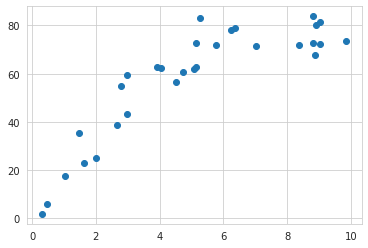

In [0]:
np.random.seed(2019)
def make_dataset(N):
    X = np.random.uniform(0,10,N)
    Y = np.random.normal(1+20*X -1.3*X**2,scale= 7)
    return X, Y

data = make_dataset(30)
plt.scatter(data[0], data[1])

[[57.72888351]] (1, 1)
[[22.84026862]
 [ 6.82467382]] (2, 1)
[[-2.73979184]
 [21.044592  ]
 [-1.37249845]] (3, 1)
[[-5.30200263]
 [24.04462297]
 [-2.13024716]
 [ 0.05083882]] (4, 1)


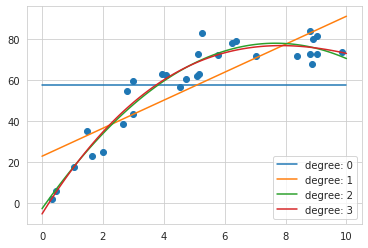

In [0]:
from numpy.linalg import inv

def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(-1,1)
    return (X**powers).T


def compute_polynomial(X, Theta):
    XP = powers_of_X(X, len(Theta) - 1) 
    Y = XP @ Theta
    return Y


plot_x_space = np.linspace(0,10,100)
plt.scatter(data[0], data[1])
for degree in range(4):
    X = powers_of_X(data[0], degree) 
    Y = data[1].reshape(-1,1)       
    Theta = np.linalg.inv(X.T @ X) @ X.T @ Y
    plt.plot(plot_x_space, compute_polynomial(plot_x_space, Theta).ravel(), 
         label="degree: %d" %(degree, ))
    print(Theta, Theta.shape)
plt.legend(loc='lower right')

# Problem 2 [2p] Ridge Regression

When the data set is small and highly dimensional (or when high degree polynomials are used) the linear regression solution may fit the noise in the data instead of capturing the general rule. We call this phenomenon overfitting and will discuss it in detail in a few lectures.

One way of preventing overfitting is to force the model's parameters to be small. We call this *regularization*. Consider the following cost function:

$$ J(\Theta) = \frac{1}{2}\sum_{i=1}^N (y^{(i)} - \Theta^T x^{(i)})^2 + \frac{\lambda}{2} \Theta^T \Theta $$

Analyze datasets sampled using the following procedure:

1. $x \propto U(0;1)$: $x$ is sampled uniformly from the  $0-1$ range.
2. $y \propto \mathcal{N}(\mu=1+2x-5x^2 + 4x^3, \sigma=0.1)$: then 
    $y$ is sampled from the Normal distribution with mean 
    $\mu=1+2x-5x^2+4x^3$ and standard deviation $0.1$

Repeat 30 times an experiment in which you sample a new training
dataset, then fit polynomials of degree 0 to 14 and use $\lambda$
value from the set $\{0, 10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}\}$.

Plot the mean training and testing errors. What is the effect of increasing $\lambda$?

Plot how the error rates depend on the the polynomial degree and regularization constant. Try to find the best value for lambda on the test set, explain the model behavoir for small lambdas and large lambdas.

Then use a small lambda for numerical stability (1e-6) and train the model on increasingly large training sets. Plot th etraining cureves (train and test error rates versus amount of training data)

The case when $\lambda$ is increasing means that we want $\theta$ to be as small as possible so we will get  many zero entries.

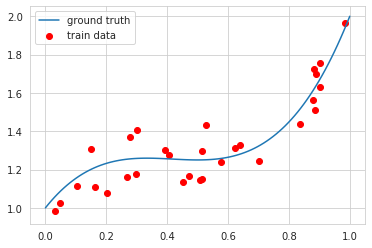

In [0]:
#
# The true polynomial relation:
# y(x) = 1 + 2x -5x^2 + 4x^3
#
# TODO: write down the proper coefficients
#
np.random.seed(2019)
true_poly_theta = np.array([1, 2, -5, 4])

def make_dataset(N, theta=true_poly_theta, sigma=0.1):
    """ Sample a dataset """
    X = np.random.rand(N)
    Y_clean = compute_polynomial(X, theta)
    Y = Y_clean + np.random.randn(N) * sigma
    return X,Y

train_data = make_dataset(30)
XX = np.linspace(0,1,100)
#YY = compute_polynomial(XX, true_poly_theta)
plt.scatter(train_data[0], train_data[1], label='train data', color='r')
plt.plot(XX, compute_polynomial(XX, true_poly_theta).ravel(), label='ground truth')
plt.legend(loc='upper left')

In [0]:
#please note: lambda is a reserved keyword in python, thus we use _lambda
def poly_fit(data, degree, _lambda):
    "Fit a polynomial of a given degree and weight decay parameter _lambda"
    X = powers_of_X(data[0], degree) # Matrix d x N
    Y = data[1].reshape(-1, 1)       # Matrix 1 x N
    #
    # TODO: implement the closed-form solution for Theta
    #
    # Please note that np.inv may be numerically unstable.
    # It is better to use np.linalg.solve or even a QR decomposition.
    lambda_matrix = np.identity((X.T @ X).shape[0],dtype = float ) * _lambda
    Theta = np.linalg.pinv(X.T@X + lambda_matrix)@X.T@Y
    return Theta

In [0]:

num_test_samples = 100
num_train_samples = [30]
lambdas = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
degrees = range(15)
num_repetitions = 30


#sample a single test dataset for all experiments
test_data = make_dataset(num_test_samples)
results = []



for (repetition,
     num_train,
     _lambda,
     degree,) in itertools.product(
         range(num_repetitions),
         num_train_samples,
         lambdas,
         degrees):
    train_data = make_dataset(num_train)
    Theta = poly_fit(train_data, degree, _lambda)
    
    X = powers_of_X(train_data[0], degree)
    Y = train_data[1].reshape(-1,1)
    
    X_test = powers_of_X(test_data[0], degree)
    Y_test = test_data[1].reshape(-1,1)
    
    train_err =sum((X @ Theta - Y)**2)/X.shape[0]
    test_err = sum((X_test @ Theta - Y_test)**2)/X_test.shape[0]
    
    
    results.append({'repetition': repetition,
                    'num_train': num_train,
                    'lambda': _lambda,
                    'degree': degree,
                    'dataset': 'train',
                    'err_rate': train_err[0]})
    results.append({'repetition': repetition,
                    'num_train': num_train,
                    'lambda': _lambda,
                    'degree': degree,
                    'dataset': 'test',
                    'err_rate': test_err[0]})
results_df = pd.DataFrame(results)
results_df.head()

,repetition,num_train,lambda,degree,dataset,err_rate
0,0,30,0.0,0,train,0.049461
1,0,30,0.0,0,test,0.051782
2,0,30,0.0,1,train,0.023711
3,0,30,0.0,1,test,0.024900
4,0,30,0.0,2,train,0.012098


In [0]:
data = results_df.sort_values(by = ['lambda'])
data['lambda'].value_counts()

0.000010    900
0.001000    900
0.010000    900
0.000100    900
0.000001    900
0.100000    900
1.000000    900
0.000000    900
Name: lambda, dtype: int64

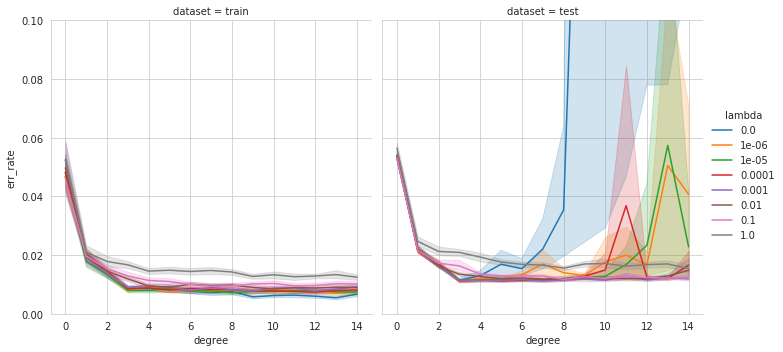

In [0]:
#sns.catplot(data = data ,x = 'degree',y = 'err_rate',hue = 'lambda',col = 'dataset' )

g = sns.FacetGrid(data,col = 'dataset',hue = 'lambda',ylim = (0,0.1),height = 5)
g.map(sns.lineplot,'degree','err_rate')
g.add_legend(
)

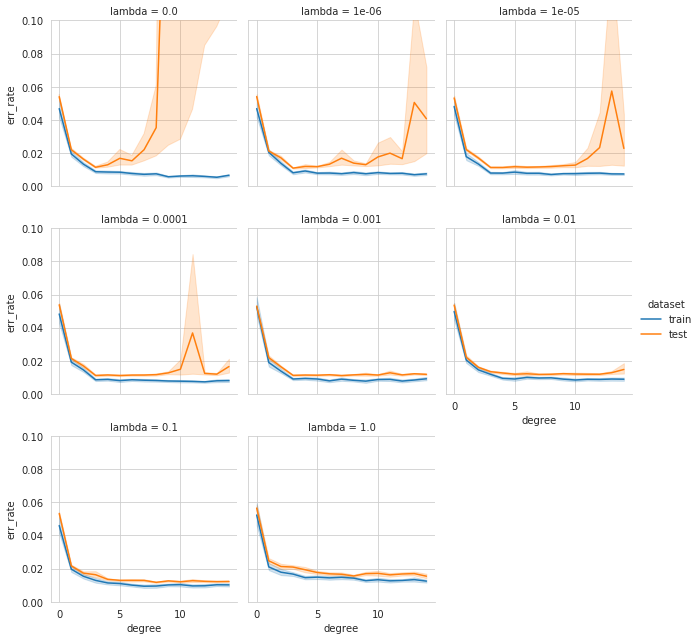

In [0]:
g = sns.FacetGrid(data,col = 'lambda',hue = 'dataset',ylim = (0,0.1),col_wrap = 3)
g.map(sns.lineplot,'degree','err_rate')
g.add_legend()

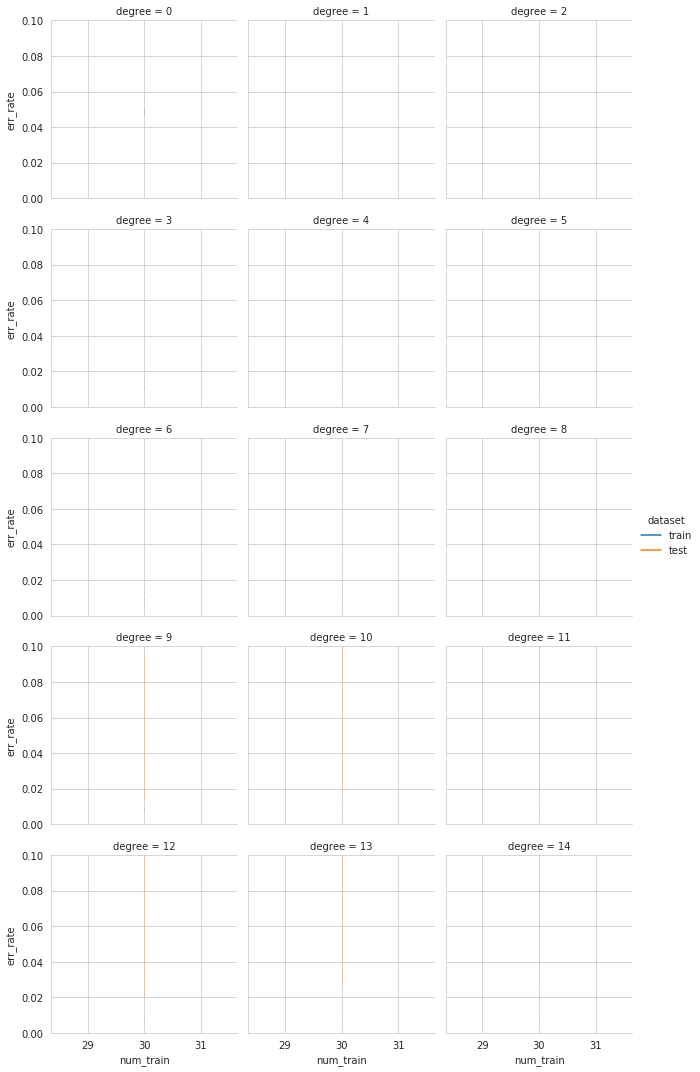

In [0]:
g = sns.FacetGrid(data,col = 'degree',hue = 'dataset',ylim = (0,0.1),col_wrap = 3)
g.map(sns.lineplot,'num_train','err_rate')
g.add_legend()

In [0]:
# TODO
#
# Plot how the error rates depend on the the polynomial degree and regularization
# constant.
# Try to find the best value for lambda on the test set, explain the model
# behavoir for small lambdas and large lambdas.
#


In [0]:
# TODO
# Now set a small regularizatoin for numerical stability  (e.g. lambda=1e-6) 
# and present the relationship between
# train and test error rates for varous degrees of the polynomial for 
# different sizes of the train set.
#


# Problem 3 [1p + 2bp] Numerical optimization

Implement the [Rosenborck function](https://en.wikipedia.org/wiki/Rosenbrock_function). Then find its optimum using the [`scipy.optimize.fmin_l_bfgs_b`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html).

In [0]:
#
# Implement the Rosenbrock function
#
# 

with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
    from common.gradients import check_gradient
# I will do it for a = 1 and b = 100
# czy to ma być przekazany wektor czy dwie wartosći ?
def rosenbrock_v(x):
    """Returns the value of Rosenbrock's function at x"""
    return (1 - x[0])**2 + 100*(x[1]- x[0]**2)**2

def rosenbrock(x):
    """Returns the value of rosenbrock's function and its gradient at x
    """
    val = rosenbrock_v(x)
    dVdX= np.array([2*(200*x[0]**3 - 200*x[0]*x[1] + x[0]-1),200*(x[1]-x[0]**2)])
    return (val, dVdX)

#
# Feel free to add your own test points.
#
for test_point in [[0., 0.],
                   [1., 1.],
                   [0.5, 1.0],
                   [1.0, 0.5]]:
    assert check_gradient(rosenbrock, np.array(test_point), prec=1e-5)

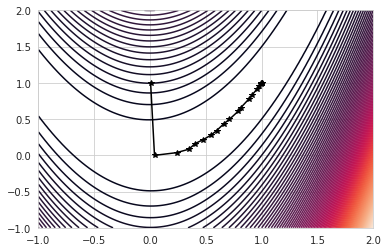

In [3]:
#
# Use scipy.optimize.fmin_l_bfgs_b
# Make a contour plot of the RosenB=brock function, plot the optimizatoin path
# on the coutnour plot
#
# Hint: to save the points you can use the callback argument!
#

import scipy.optimize as sopt
lbfsg_hist = []
def save_hist(x):
    lbfsg_hist.append(np.array(x))

x_start = [0.,2.]
lbfsgb_ret = sopt.fmin_l_bfgs_b(rosenbrock, x_start, callback=save_hist)

path = pd.DataFrame(lbfsg_hist)

# TODO: plot the countours of the function and overlay the optimization trajectory
MX,MY = np.meshgrid(np.linspace(-1,2,100), np.linspace(-1,2,100))
Z = np.array([MX,MY]).reshape(2,-1)
VR = rosenbrock_v(Z)
plt.contour(MX,MY,VR.reshape(MX.shape), 100)
plt.plot(path.iloc[:,0], path.iloc[:,1], '*-k')


Tried step length: 1.000000, decrease: 399.994981, m: 799.994987, cond_value 79.999499
Accepted step length: 1.000000, new value: 1.005019
Tried step length: 1.000000, decrease: -99.495289, m: 2.007516, cond_value 0.200752
Tried step length: 0.500000, decrease: -5.528293, m: 2.007516, cond_value 0.100376
Tried step length: 0.250000, decrease: 0.046584, m: 2.007516, cond_value 0.050188
Tried step length: 0.125000, decrease: 0.210722, m: 2.007516, cond_value 0.025094
Accepted step length: 0.125000, new value: 0.794297
Tried step length: 1.000000, decrease: 0.149031, m: 0.421512, cond_value 0.042151
Accepted step length: 1.000000, new value: 0.645266
Tried step length: 1.000000, decrease: 0.284919, m: 0.494170, cond_value 0.049417
Accepted step length: 1.000000, new value: 0.360347
Tried step length: 1.000000, decrease: -0.739648, m: 0.384515, cond_value 0.038452
Tried step length: 0.500000, decrease: 0.091528, m: 0.384515, cond_value 0.019226
Accepted step length: 0.500000, new value: 0.

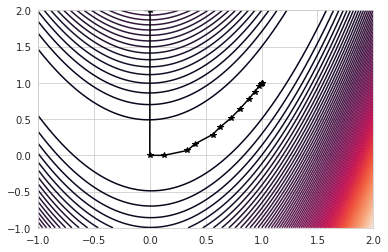

In [0]:
#
# Bonus problem
#

# Newtod-Raphson Method

def rosenbrock_hessian(x):
    #TODO: compute the value, gradient and Hessian of Rosenbrock's function'
        val = rosenbrock_v(x)
        dVdX= np.array([2*(200*x[0]**3 - 200*x[0]*x[1] + x[0]-1),200*(x[1]-x[0]**2)])
        H = np.array([[1200*x[0]-400*x[1] + 2,-400*x[0]],
                      -400*x[0],200])
        return [val,dVdX, H]

def Newton(f, Theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):
    
    # TODO:
    #  - implement the newton method and a simple line search
    #  - make sure your function is resilient at critical points (such as seddle points)
    #  - if the Newton direction is not minimizing the function, use the gradient for a few steps
    #  - try to beat L-BFGS on the bmber of function evaluations needed!
        i = 0 
        x_start = Theta
        while True:
            i += 1
            grad = f(x_start)[1]
            H = f(x_start)[2]
            x_start = x_start + alpha

            

    
        return Theta, history, fun_evals

Xopt, Xhist, fun_evals = Newton(rosenbrock_hessian, x_start, alpha=1e-0, stop_tolerance=1e-10, max_steps=1e6)
Xhist_ = np.array([[x[0][0], x[0][1]] for x in Xhist])

print("Found optimum at %s in %d steps (%d function evals)(true minimum is at [1,1])" % (Xopt, len(Xhist), fun_evals))

MX,MY = np.meshgrid(np.linspace(-1,2,100), np.linspace(-1,2,100))
Z = np.array([MX,MY]).reshape(2,-1)
VR = rosenbrock_v(Z)
plt.contour(MX,MY,VR.reshape(MX.shape), 100)
plt.plot(Xhist_[:,0], Xhist_[:,1], '*-k')

# Problem 4 (Logistic Regression) [1p]

Linear regression is suitable for problems, where
the forecasted values are real numbers. We use logistic regression,
when we want to label the data with $0$ and $1$.

Let $x\in \mathbb{R}^n$ be a vector of $n$ real numbers, and
$y\in \{0,1\}$ the given class label. Similarly to what was shown
during the lecture, we add an additional element $x_0=1$
to vector $x$, to account for the bias term (and simplify the equations).

Similarly to linear regression, vector
$\Theta\in \mathbb{R}^{n+1}$ parametrizes the model
($n$ coefficients describes the data, the remaining one is the intercept).
In logistic regression, we model conditional probability that
sample $x$ belongs to class $1$ as:

\begin{equation}
p(\text{class}=1|x, \Theta)=h_\Theta(x) = \sigma\left(\sum_{j=0}^n \Theta_j x_j\right) 
= \sigma\left(\Theta^T x \right),
\end{equation}

where $\sigma(a) = \frac{1}{1+\exp(-a)}$ is being called the logistic sigmoid
(a function, which plot is s-curved).

An unknown sample $x$ is being labeled $1$ if
$h_\Theta(x)\geq 0.5$, or equivalently, $\Theta^T x \geq 0$.

Classification mismatch between the forecasted values and
the data is being measured most of the time with cross-entropy:

\begin{equation}
    J(\Theta) = - \sum_{i=1}^m y^{(i)} \log \left(h_\Theta (x^{(i)})\right) + (1-y^{(i)}) \log \left(1-h_\Theta (x^{(i)})\right),
\end{equation}

assuming $0\log(0)=0$.

Use logistic regression to distinguish
  _Versicolor_ and _Virginica_ irises. Use only the
  `petal length` and `petal width` features. Use either
  Gradient Descent, or L-BFGS to solve for the optimal $\Theta$.
  Prepare the scatterplot of the data and plot the class separation
  boundary found by logistic regression.

In [0]:
from sklearn import datasets
iris = datasets.load_iris()
print('Features: ', iris.feature_names)
print('Targets: ', iris.target_names)
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


Text(0, 0.5, 'petal_width')

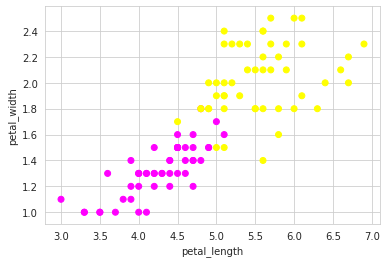

In [0]:
#Extract the petal_length and petal_width of versicolors and virginicas

IrisX = np.vstack([np.ones_like(petal_length), petal_length, petal_width])
IrisX = IrisX[:, iris.target!=0]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target!=0]-1).reshape(1,-1).astype(np.float64)

plt.scatter(IrisX[1,:], IrisX[2,:], c=IrisY.ravel(), cmap='spring')
plt.xlabel('petal_length')
plt.ylabel('petal_width')

Njet


(2.7951433691756273, 7.104856630824373)

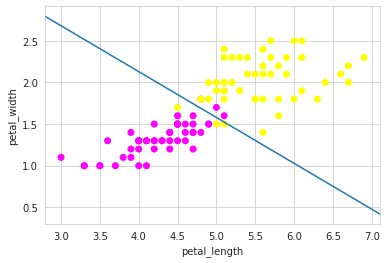

In [0]:

def logreg_loss(Theta, X, Y):
    #
    # Write a logistic regression cost suitable for use with fmin_l_bfgs
    #

    g = lambda X,Theta : 1/ (1+np.exp(-X @ Theta))
    nll = -1*(Y * np.log(g(X,Theta)) + (1-Y)*np.log(1-g(X,Theta))).sum()
    grad = (Y - g(X,Theta)).reshape(1,-1) @ X

    #reshape grad into the shape of Theta, for fmin_l_bfsgb to work
    return (nll, -grad.reshape(Theta.shape))

Theta0 = np.zeros((3))

#
# Call a solver
#
ThetaOpt = sopt.fmin_l_bfgs_b(lambda Theta: logreg_loss(Theta, IrisX.T, IrisY), np.array(Theta0))[0]


#
# Now plot the found separation line 
# 

plt.scatter(IrisX[1,:], IrisX[2,:], c=IrisY.ravel(), cmap='spring')
plt.xlabel('petal_length')
plt.ylabel('petal_width')
pl_min, pl_max = plt.xlim()
pl = np.linspace(pl_min, pl_max, 1000)
plt.plot(pl, -(ThetaOpt[0]+ThetaOpt[1]*pl)/ThetaOpt[2])
plt.xlim(pl_min, pl_max)

# Problem 5 [3p]

  The least squares method results in estimates that approximate
  the conditional mean of the response variable given certain values
  of the predictor variables.  However, for many applications we are interested
  in a median or other percentile rather than the mean of the response
  variable. An approximation of a percentile can be achieved
  indirectly by using the least squares method to fit a model,
  assuming a gaussian distribution on residuals of this model and
  calculating the required percentile of the gaussian distribution.
  The problems with this commonly used technique appear when the
  distribution of residuals does not follow a gaussian distribution.

  The quantile regression
  (https://en.wikipedia.org/wiki/Quantile_regression) aims at
  directly estimating a value of the conditional percentile of the
  response variable. It is often use in e.g. sales forecasting, where
  we are interested in e.g. keeping enough items to have a 90% chance
  to cover the demand. In quantile regression, instead of minimizing the mean squared error,
  quantile regression minimizes a different cost function namely:
  \begin{equation}
  f_{\tau} = \left\{
    \begin{array}{rl}
      \tau\cdot x & \text{if } x \geq 0,\\
      -(1-\tau)\cdot x & \text{if } x < 0,
    \end{array} \right.
  \end{equation}
  where $\tau$ is the precentile of interest.


Download the house pricing data set from
    https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv. To
    load it into Python, you can use the `pandas.read_csv`
    function, similarly to how we read the height/weight table in the
    notebook for lecture 3.

    This data contains information about areas and prices of around
    5000 houses offered for sale. Imagine you want to buy a 60 squared
    meters flat. How much money do you need to have to be able to
    choose between $75\%$ of all flats offered for sale?

1. **[1.5p]** Fit a linear regression model to the dependance of a house price
    on its area using the least squares method. Fit a Gaussian
    distribution to the residuals and calculate the 75 percentile of
    this distribution (you can look it up in a percentile table, or
    use the `scipy.stats.norm.ppf` function). Check the goodness of fit
    of your model by calculating the ratio of prices below the
    estimated 75 percentile. Understand the reason of the quality of
    the model by plotting a histogram of residuals and noting that
    they do not seem to follow a Gaussian distribution.
    How many samples are within the confidence interval? Is it too large or too small?
2. **[1.5]** Fit a quantile regression model by minimizing the $f_{\tau}$
    function. To fit the model write a function returning the cost,
    and its derivative (you can assume that the derivative is 0 at the
    singular points).  Use the L-BFGS solver (without step size
    control the GD algorithm does not converge to good solutions). You
    can start the solver from the least squares solution. Check the
    goodness of fit as described above.

    Now you can calculate the 75 percentile price value for a 60
    squared meters flat using the more adequate model. 
    
    **Note**: Technically, we can not use a gradient-based
    optimization method to minimize the $f_{\tau}$ loss because it
    doesn't have a derivative at $x=0$. One solution is to use a
    subgradient method
    https://en.wikipedia.org/wiki/Subderivative. It is also
    possible to use a smooth loss function -- common variants are the
    Huber loss (https://en.wikipedia.org/wiki/Huber_loss) or a
    variant of the smooth approximation to the absolute value
    $\text{abs}(x) \approx \sqrt{x^2+\epsilon}$ with a small
    $\epsilon$. However, just ignoring the singular points tends to
    work well in practice.


In [0]:
import pandas as pd
import scipy.optimize as sopt
from scipy.stats import norm
import numpy as np 

In [0]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv',
    index_col=0)
data.head()

,rooms,area,price
0,3,66.80,367.801
1,3,55.03,289.458
2,4,70.80,389.000
3,1,29.02,195.695
4,2,45.76,265.754


In [0]:
X = np.vstack((np.ones_like(data.rooms), data.area))
X = X.T

In [0]:
Y = np.asarray(data.price)[None,:]
#X.T @ np.array([1,2])

In [0]:
Theta = np.linalg.pinv(X.T @ X) @ X.T @ Y.reshape(-1,1)
Theta

array([[-14.09901832],
       [  6.54132271]])

(0, 3000)

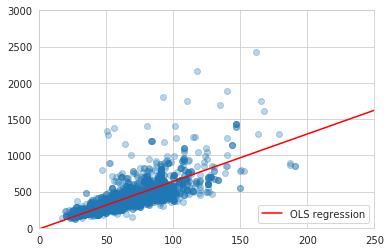

In [0]:
plot_x_space = np.linspace(0,250,1000)
X_lin_matrix = np.column_stack([np.ones_like(plot_x_space ),plot_x_space])
Y_val = X_lin_matrix @ Theta
plt.scatter(data['area'], data['price'],alpha = 0.3)
plt.plot(plot_x_space,Y_val.ravel() , 
         label="OLS regression",color = 'red')
plt.legend(loc='lower right')
plt.xlim([0,250])
plt.ylim([0,3000])

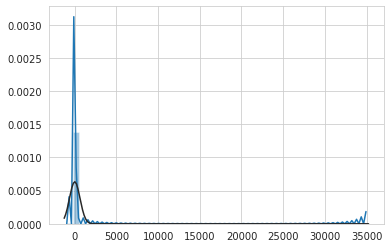

In [0]:
import seaborn as sns
Y_hat = X @ Theta
err = Y.reshape(1,-1) - Y_hat.ravel()
sns.distplot(err,fit =norm)

In [0]:
np.sum(err**2)

2346329812.9941254

In [0]:
np.percentile(err,q = 75)

11.538663306005333

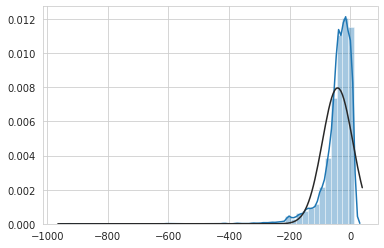

In [0]:
Y_hat_list = Y_hat.reshape(1,-1)
err_low_75 = Y[err<11.5] - Y_hat_list[err<11.5]
sns.distplot(err_low_75,fit =norm)

In [0]:
np.sum(err**2)-np.sum(err_low_75 **2) # znaczna poprawa po zabraniu cześci obserwacji odstających

2327354628.488984

ZAD 2


In [0]:
def quantile_loss(Theta,X,Y,quantile):
    value = X @ Theta
    err =  Y - value.ravel()
    nll = (err[err>0]*quantile).sum() + (err[err<0]*(quantile-1)).sum()
    err[err>0] = quantile
    err[err<0] = -1*(1-quantile)
    theta0 = np.sum(err)
    theta1 = np.dot(err, X[:,1])
    grad = np.array([theta0,theta1[0]])#/X[:,1].shape[0]
    
    return(nll,-grad.reshape(Theta.shape))

In [0]:
Theta0 = np.array([-14,6])
Theta_quantile = sopt.fmin_l_bfgs_b(lambda Theta: quantile_loss(Theta, X, Y,0.75), np.array(Theta0))[0]

In [0]:
Y_quantile_075 = X @ Theta_quantile
err_quant075 = Y.reshape(1,-1) - Y_quantile_075.ravel()
[np.percentile(err_quant075,q = 75),Theta_quantile]
#sns.distplot(err_quant075,fit = norm)

[-0.0009736764023671185, array([6.60462317, 6.36069299])]

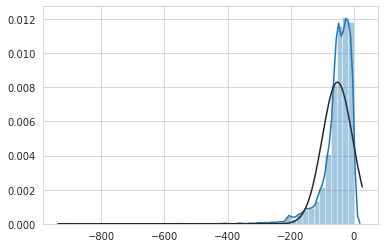

In [0]:
Y_hat_list = Y_quantile_075.reshape(1,-1)
err_low_75 = Y[err_quant075<-0.0009] - Y_hat_list[err_quant075<-0.0009]
sns.distplot(err_low_75,fit =norm)

In [0]:
Theta

array([[-14.09901832],
       [  6.54132271]])

Quantile 0.1: 
 Theta _quantile [47.34391363  4.13602768] 
Fraction of negative errs : 0.1,(should be 0.1)

Quantile 0.25: 
 Theta _quantile [20.63939131  5.02343976] 
Fraction of negative errs : 0.2501689189189189,(should be 0.25)

Quantile 0.5: 
 Theta _quantile [11.7200538   5.76892757] 
Fraction of negative errs : 0.5001689189189189,(should be 0.5)

Quantile 0.75: 
 Theta _quantile [6.60462317 6.36069299] 
Fraction of negative errs : 0.75,(should be 0.75)

Quantile 0.95: 
 Theta _quantile [-60.91947135   9.30200416] 
Fraction of negative errs : 0.95,(should be 0.95)



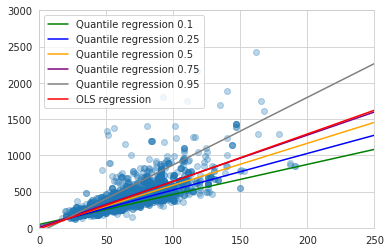

In [0]:
plot_x_space = np.linspace(0,250,1000)
X_lin_matrix = np.column_stack([np.ones_like(plot_x_space ),plot_x_space])

jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
plt.scatter(data['area'], data['price'],alpha = 0.3)

for i,j in zip([0.1,0.25,0.5,0.75,0.95],['green','blue','orange','purple','gray']):
    Theta_quantile = sopt.fmin_l_bfgs_b(lambda Theta: quantile_loss(Theta, X, Y,i), np.array(Theta0))[0]
    print(f"Quantile {i}: \n Theta _quantile {Theta_quantile} ")
    Y_val = X_lin_matrix @ Theta_quantile
    Y_hat = X @ Theta_quantile
    errors = Y-Y_hat
    fraction = np.sum(errors<0)/errors.shape[1]
    print(f"Fraction of negative errs : {fraction},(should be {i})\n")
    #plt.scatter(data['area'], data['price'],alpha = 0.3)
    plt.plot(plot_x_space,Y_val.ravel() , 
         label=f"Quantile regression {i}",color = j)
   # plt.legend(loc='upper left')
    plt.xlim([0,250])
    plt.ylim([0,3000])

Y_val = X_lin_matrix @ np.array([[-14.09901832],
       [  6.54132271]])
plt.plot(plot_x_space,Y_val.ravel() , 
         label="OLS regression",color = 'red')
plt.legend(loc='upper left')

# Problem 6 [3p] Random Forests v2

Repeat Problem 4 from Assignment 2 using [SKlearn's Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Since they don't support categorical attributes, use the numerical variant of the German Credit dataset (cf. the AdaBoost demo at https://github.com/janchorowski/ml_uwr/blob/fall2019/lectures/05_adabost_demo.ipynb), or try to encode them using the [1-Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).


**NB:** If you did Assignment 2 Problem 4, you automatically get 2 points for this problem. We highly advise to not do this problem, but do a bonus one instead.





# Problem 7 [3bp] Lasso and Adaboost

Boosting is similar to Lasso regression: it greedily selects classifiers that lead to the largest decrease in the train error. 

However, once boosting adds a tree to the ensemle, it doesn't revisit this decision. We can try to get a small improvement by trying to refit the parameters in the tree (the tree weights and distributions in leaves) using some global optimization algorithm, such as LASSO.

In this exercise:
1. Train a boosting classifier on some dataset (e.g. German Credit from Problem 6).
2. Then use the tree to build a new representation of data:
    1. Take each sample and put it through all trees.
    2. For each tree, record the leaf index.
   
   Thus, a sample is represented by the leaf ids. Encode them using 1-hot encoding and train a LASSO classifier on this new representation.


In [0]:
Theta_075 = np.linalg.pinv(X.T @ X) @ X.T @ Y.reshape(-1,1)

(300, 100, 1)

In [0]:
bound= np.percentile(err,q = 95)#
#Theta_075 = np.linalg.pinv(X[err>bound,:].T @ X[err>bound,:]) @ X[err>bound,:].T @ Y[err>bound].reshape(-1,1)
#X[err>bound]
np.sum(err>bound)
idx = err.reshape(X.shape[0])
X[idx>bound,:]
Theta_075 = np.linalg.pinv(X[idx>bound,:].T @ X[idx>bound,:]) @ X[idx>bound,:].T @ Y[err>bound].reshape(-1,1)
Theta_075

array([[478.10599598],
       [  6.42022871]])

(0, 3000)

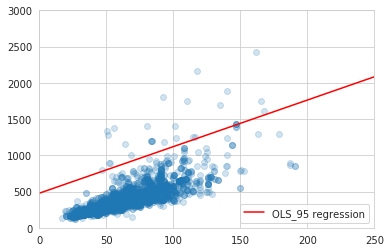

In [0]:
plot_x_space = np.linspace(0,250,1000)
X_lin_matrix = np.column_stack([np.ones_like(plot_x_space ),plot_x_space])
Y_val = X_lin_matrix @ Theta_075
plt.scatter(data['area'], data['price'],alpha = 0.2)
plt.plot(plot_x_space,Y_val.ravel() , 
         label="OLS_95 regression",color = 'red')
plt.legend(loc='lower right')
plt.xlim([0,250])
plt.ylim([0,3000])